In [1]:
! nvidia-smi

Thu Nov 10 09:41:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   30C    P0   104W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [2]:
import os, random

# Makes sure the script has acess to one GPU
cuda_device = 5
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

In [3]:
# "Basic" py library
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
from tqdm import tqdm  # generats progress bar to controll steps

import torch # Pytorch, Meta's library for ML
import torch.nn as nn # torch module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset


In [4]:
def set_seed(seed: int, set_random=True):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    if set_random:
        random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [5]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed 
seed = 31
set_seed(seed)

In [6]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer                      # the Tokenizer model
        self.data      = dataframe                      # the full dataset
        self.report    = dataframe.report               # the text data (i.e., the reports)
        self.targets   = self.data.Report_as_Multilabel # labels' list to classify
        self.max_len   = max_length                     # max length fro truncation

    def __len__(self):
        return len(self.report)

    def __getitem__(self, index):
        report = str(self.report[index])
        report = " ".join(report.split())

        inputs = self.tokenizer.encode_plus(
            report,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }
    
# Creating the dataset and dataloader for the neural network
def get_Fold(k_seed, train_size = 0.8):
    
    train_dataset = final_df_dataset.sample(frac=train_size, random_state=k_seed)
    test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    test_params = {
        'batch_size': valid_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader  = DataLoader(testing_set, **test_params)
    
    return training_loader, testing_loader

# Creating the customized model, by adding a drop out and a dense layer on top of 
# the BERT (or any other) model, to get the final output. 
class BERTClass(torch.nn.Module):
    def __init__(self, model_name, n_classes, freeze_BERT=False, layer=-1, idx=0):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained(model_name)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, n_classes)
        self.layer = layer
        self.idx   = idx  
        # Froze the weight of model aside of the classifier
        if froze_model_layer:
            print("Freezing the layer of BERT model")
            for name, param in self.l1.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False
                    
    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = output_1.last_hidden_state[:, -1, :]
        output_2 = self.l2(output_1)
        output   = self.l3(output_2)
        return output

# Loss function 
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Training regime
def train(epoch, model, training_loader, optimizer, return_losses=False):
    Losses = []
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            Losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if return_losses:
        return Losses
    
# Validate (test) the model
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[Dataset and Model Setup](#setup)

[Training and Evaluation](#train_eval)

[Analysis](#analysis)

[K-Fold Experiment](#kfold)

## Loading data<a id='intro'></a>

In [7]:
# Load the dataset in CSV
dream_records = pd.read_csv(
    "Reports_DreamerEmotions_PCACho_tsneCho_KMCluster2_KMCluster6_2WSA_6WSA.csv"
)

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}

Convert each set of labels/Emotion is a list signaling the prsence/absence of each emotion.

In [8]:
emotions_list = list(Coding_emotions.keys())
emotions_list.remove("Missing")

report_as_multi_label = []
for rprt_emtn_lst in tqdm(dream_records["Emotions"]):
    lcl_report_as_multi_label = []
    for emotion_acronim in emotions_list:
        if emotion_acronim in rprt_emtn_lst:
            lcl_report_as_multi_label.append(1)
        else:
            lcl_report_as_multi_label.append(0)
    report_as_multi_label.append(lcl_report_as_multi_label)

dream_records["Report_as_Multilabel"] = report_as_multi_label

# final_df_dataset = dream_records

final_df_dataset = dream_records[~dream_records["# Emotions"].isin([0])].reset_index(drop=True)

100%|████████████████████████████████████| 1845/1845 [00:00<00:00, 23877.23it/s]


In [9]:
final_df_dataset.columns

Index(['gender', 'age', 'type', 'collection', 'id', 'time', 'date', 'number',
       'report', '# words', 'Emotions', '# Emotions', 'TSNE_x', 'TSNE_y',
       'PCA_x', 'PCA_y', 'Kmean_Cluster_6', 'Kmean Cluster_2', '2W_SA_label',
       '2W_SA_score', '6W_SA_dict', 'Report_as_Multilabel'],
      dtype='object')

In [10]:
final_df_dataset = final_df_dataset[["report", "Report_as_Multilabel"]]

## Dataset and Model Setup<a id='setup'></a>

In [11]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 8 # always use power of 2!
valid_batch_size  = 4
learning_rate     = 1e-05
froze_model_layer = False 

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

In [12]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset = final_df_dataset.sample(frac=train_size, random_state=seed)
test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset:  {}".format(final_df_dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset:  {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, max_length)
testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

FULL Dataset:  (778, 2)
TRAIN Dataset: (622, 2)
TEST Dataset:  (156, 2)


In [13]:
train_params = {
    'batch_size': train_batch_size,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': valid_batch_size,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader  = DataLoader(testing_set, **test_params)

In [14]:
model_tuned = BERTClass(
    model_name=model_name, 
    n_classes=len(emotions_list), 
    freeze_BERT=False
)

model_tuned.to(device)

optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training and Evaluation<a id='train_eval'></a>
Training a model on a single split 

In [15]:
for ep in range(epochs):
    train(ep, model_tuned, training_loader, optimizer_tuned)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  0.7251710295677185
Epoch: 1, Loss:  0.5469126105308533
Epoch: 2, Loss:  0.5461908578872681
Epoch: 3, Loss:  0.4007751941680908
Epoch: 4, Loss:  0.36560940742492676
Epoch: 5, Loss:  0.21447134017944336
Epoch: 6, Loss:  0.05728339031338692
Epoch: 7, Loss:  0.05159328132867813
Epoch: 8, Loss:  0.023010646924376488
Epoch: 9, Loss:  0.03386959433555603


In [16]:
outputs, targets = validation(model_tuned, testing_loader)
outputs = np.array(outputs) >= 0.5

In [17]:
pd.DataFrame.from_dict(
    metrics.classification_report(
        targets,
        outputs,
        target_names=emotions_list,
        zero_division=0,
        output_dict=True,
    ), 
    orient='index',
).round(2)

,precision,recall,f1-score,support
AN,0.88,0.81,0.85,27
AP,0.85,0.90,0.87,68
SD,0.78,0.82,0.80,22
CO,0.86,0.61,0.72,31
HA,0.91,0.91,0.91,32
micro avg,0.86,0.83,0.84,180
macro avg,0.86,0.81,0.83,180
weighted avg,0.86,0.83,0.84,180
samples avg,0.85,0.84,0.84,180


## Analysis<a id='analysis'></a>

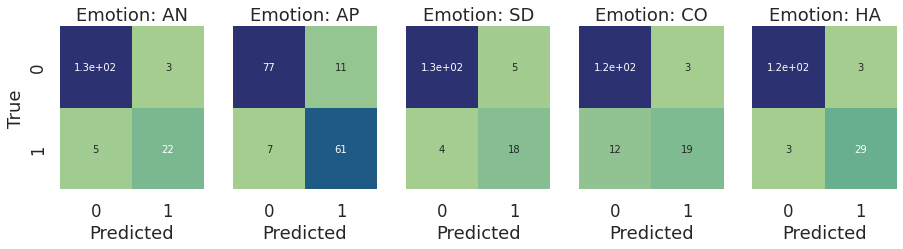

In [18]:
emotions_CM = metrics.multilabel_confusion_matrix(
    targets,
    outputs,
)

plt.figure(figsize=(15, 3))
for cnt, cm in enumerate(emotions_CM): 
    
    plt.subplot(1,5,cnt+1) 
    g = sns.heatmap(cm, cmap="crest", cbar=False, annot=True)
    plt.title("Emotion: {}".format(emotions_list[cnt]))
    plt.xlabel("Predicted")
    if cnt == 0:
        plt.ylabel("True")
    else:
        g.set_yticklabels(["", ""])
        
plt.show()

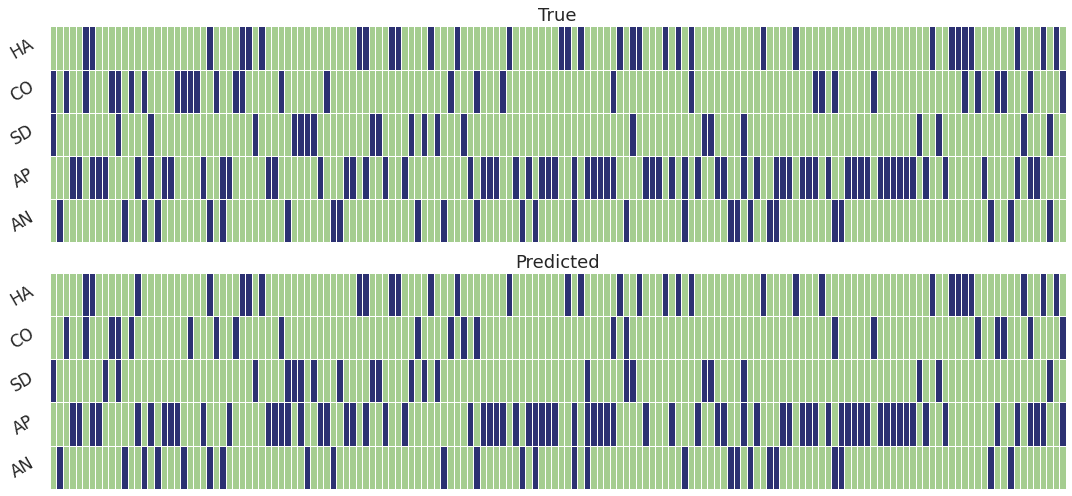

In [20]:
plt.figure(figsize=(15, 7))
for cnt, [name, data] in enumerate({"True":targets, "Predicted":outputs}.items()): 
    
    rot_data = np.rot90(data)
    _bar = True if cnt != 0 else False
    plt.subplot(2,1,cnt+1)
    g = sns.heatmap(
            rot_data, 
            cmap="crest",
            linewidth=.8,
            xticklabels=False, 
            yticklabels=list(reversed(emotions_list)),
            cbar=False,
    )
    g.set_yticklabels(g.get_yticklabels(), rotation=30)        
    plt.title("{}".format(name))
    
plt.tight_layout()
plt.show()

In the "DNA" plot above, each column represents a single Dream Report, while each row reflects a specific emotion. The rectangles represent the labels of each report. Blue indicates the presence of that label (i.e., the report was labelled as containing that emotion), while green indicates its absence.

## K-Fold Cross Validation<a id='kfold'></a>
In previous experiment, we observed a jump in perfprmance after 5 epochs. The K-Fold experimetn should allow us to understand how stable such jump is, acorss different random samples of the dataset.

In [11]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 8 # always use power of 2!
valid_batch_size  = 4
learning_rate     = 1e-05
froze_model_layer = False 
K_fold            = 5

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

In [12]:
SCORES, LOSSES = [], []
for fold in range(K_fold):

    print('Fold {}'.format(fold + 1))
    rand_int = random.randint(0, 10000)
    train_loader, testing_loader = get_Fold(rand_int, train_size = 0.8)

    # makes sure the seed for model init is the same
    set_seed(seed, set_random=False) 
    
    # Set Model and Optmizer (for each fold)
    model_tuned = BERTClass(
        model_name=model_name, 
        n_classes=len(emotions_list), 
        freeze_BERT=False
    )

    optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
    ) 
    
    model_tuned.to(device)
    
    #Train and test the model
    for ep in range(epochs):
        train_losses = train(
            ep, 
            model_tuned, 
            train_loader, 
            optimizer_tuned, 
            return_losses=True,
        )
        LOSSES.append(train_losses)
    
    print("Testing the Model")
    outputs, targets = validation(model_tuned, testing_loader)
    outputs = np.array(outputs) >= 0.5    
    
    # send the model back to cpu and delete
    model_tuned.to("cpu")
    del model_tuned 
    
    # Compute and print results
    results_df = pd.DataFrame.from_dict(
        metrics.classification_report(
            targets,
            outputs,
            target_names=emotions_list,
            zero_division=0,
            output_dict=True,
        ), 
        orient='index',
    ).round(2)
    
    f1_samp_av = results_df.at["samples avg", "f1-score"]
    print("F1 samples avg.: {}".format(f1_samp_av), end = "\n")
    SCORES.append(f1_samp_av)

Fold 1


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max l

Epoch: 0, Loss:  0.7142664790153503
Epoch: 1, Loss:  0.6288732886314392
Epoch: 2, Loss:  0.47143539786338806
Epoch: 3, Loss:  0.3421362340450287
Epoch: 4, Loss:  0.21221759915351868
Epoch: 5, Loss:  0.06725975126028061
Epoch: 6, Loss:  0.03204110264778137
Epoch: 7, Loss:  0.04540674760937691
Epoch: 8, Loss:  0.01690652407705784
Epoch: 9, Loss:  0.01999722234904766
Testing the Model
F1 samples avg.: 0.87
Fold 2


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` a

Epoch: 0, Loss:  0.6760182976722717
Epoch: 1, Loss:  0.4026985168457031
Epoch: 2, Loss:  0.560945987701416
Epoch: 3, Loss:  0.5252399444580078
Epoch: 4, Loss:  0.28452640771865845
Epoch: 5, Loss:  0.11542550474405289
Epoch: 6, Loss:  0.06017047166824341
Epoch: 7, Loss:  0.030977372080087662
Epoch: 8, Loss:  0.026989465579390526
Epoch: 9, Loss:  0.029974211007356644
Testing the Model
F1 samples avg.: 0.82
Fold 3


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` a

Epoch: 0, Loss:  0.6716623306274414
Epoch: 1, Loss:  0.48246413469314575
Epoch: 2, Loss:  0.45767608284950256
Epoch: 3, Loss:  0.1634739637374878
Epoch: 4, Loss:  0.1641058325767517
Epoch: 5, Loss:  0.13181106746196747
Epoch: 6, Loss:  0.029951825737953186
Epoch: 7, Loss:  0.01999967359006405
Epoch: 8, Loss:  0.019200420007109642
Epoch: 9, Loss:  0.021248728036880493
Testing the Model
F1 samples avg.: 0.87
Fold 4


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` a

Epoch: 0, Loss:  0.7364206910133362
Epoch: 1, Loss:  0.4020026624202728
Epoch: 2, Loss:  0.44552093744277954
Epoch: 3, Loss:  0.3035637438297272
Epoch: 4, Loss:  0.1057169958949089
Epoch: 5, Loss:  0.19502641260623932
Epoch: 6, Loss:  0.08095550537109375
Epoch: 7, Loss:  0.07792723178863525
Epoch: 8, Loss:  0.027644097805023193
Epoch: 9, Loss:  0.030544554814696312
Testing the Model
F1 samples avg.: 0.91
Fold 5


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` a

Epoch: 0, Loss:  0.750389575958252
Epoch: 1, Loss:  0.5414676070213318
Epoch: 2, Loss:  0.48319578170776367
Epoch: 3, Loss:  0.5341503024101257
Epoch: 4, Loss:  0.16450099647045135
Epoch: 5, Loss:  0.12409074604511261
Epoch: 6, Loss:  0.056649576872587204
Epoch: 7, Loss:  0.059060242027044296
Epoch: 8, Loss:  0.03171442076563835
Epoch: 9, Loss:  0.023519502952694893
Testing the Model
F1 samples avg.: 0.89


In [25]:
epoch_loss_df = [] 
for f_i, fold in enumerate(np.array(LOSSES).reshape(K_fold, epochs)):
        for e_i, ep_lss in enumerate(fold):
            epoch_loss_df.append([e_i+1, ep_lss, f_i+1])

epoch_loss_df = pd.DataFrame(epoch_loss_df, columns=["Epoch", "Loss", "Fold"])

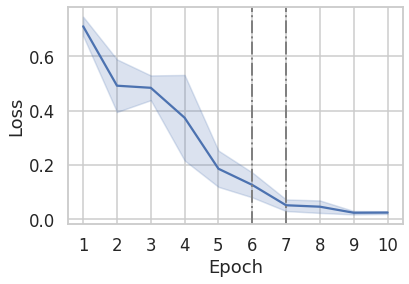

In [54]:
g = sns.lineplot(
    epoch_loss_df, 
    x="Epoch", 
    y="Loss", 
    errorbar=("sd", 1)
)

g.set_xticks([i+1 for i in range(10)])
g.set_xticklabels([i+1 for i in range(10)])
g.axvline(6, ls='-.', color="gray", linewidth=2)
g.axvline(7, ls='-.', color="gray", linewidth=2)

In [44]:
print("Mean F1 samples avg.:{:.0f} ± {:.2f}".format(100*np.mean(SCORES), 100*np.std(SCORES)))

Mean F1 samples avg.:87 ± 2.99
